# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [9]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from typing import NoReturn
from tqdm import tqdm

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

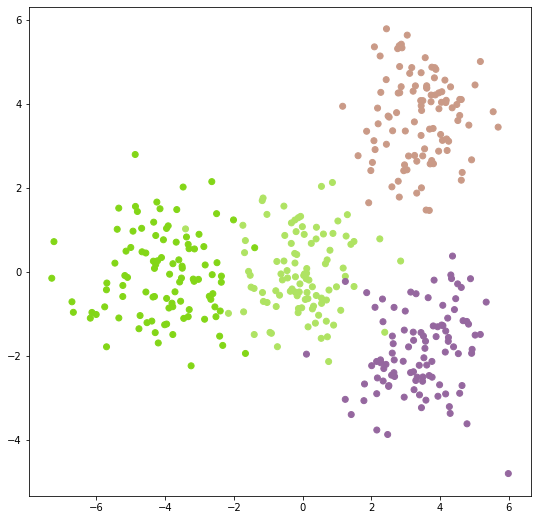

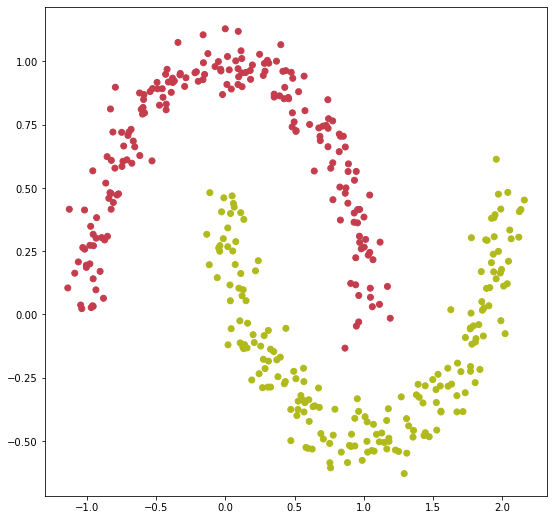

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        if init == 'random':
            self.init = self.random_init
        elif init == 'sample':
            self.init = self.sample_init
        elif init == 'k-means++':
            self.init = self.kmeans_init
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        return
    
    def random_init(self, X: np.array):
        self.centroids = np.random.rand((self.n_clusters))
        return
    
    def sample_init(self, X: np.array):
        self.centroids = X[np.random.choice(X.shape[0], size=self.n_clusters, replace=False)]
        return
    
    def kmeans_init(self, X: np.array):
        n_clusters = self.n_clusters
        centroids = np.array([[0] * X.shape[1]] * n_clusters)
        self.centroids = centroids
        centroids[0] = X[np.random.choice(X.shape[0])]
        dist_to_nearest_centroid = np.array([np.linalg.norm(X[j] - centroids[0]) ** 2
                                             for j in range(X.shape[0])])
        nearest_centroid = np.zeros(X.shape[0])
        for k in range(1, n_clusters):
            nearest_centroid = np.array([np.argmin([np.linalg.norm(X[i] - self.centroids[j])
                                        for j in range(k)])
                                        for i in range(X.shape[0])])
            dist_to_nearest_centroid = np.array([np.linalg.norm(X[i] - nearest_centroid[i]) ** 2
                                                for i in range(X.shape[0])])
            centroids[k] = X[np.random.choice(X.shape[0], p=dist_to_nearest_centroid/sum(dist_to_nearest_centroid))]
        self.centroids = centroids
            
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self.init(X)
        n_clusters = self.n_clusters
        max_iter = self.max_iter
        cluster = np.zeros(X.shape[0])  # cluster[i] == current X[i]'s cluster
        for i in range(max_iter):
            cluster = self.predict(X)
            self.centroids = np.array([np.array(np.matrix([X[j] for j in range(X.shape[0]) if cluster[j] == i]).mean(0))[0]
                                  if len([X[j] for j in range(X.shape[0]) if cluster[j] == i]) != 0
                                  else self.centroids[i] for i in range(n_clusters)])
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        return np.array([np.argmin([np.linalg.norm(X[i] - self.centroids[j])
                         for j in range(self.n_clusters)])
                         for i in range(X.shape[0])])

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

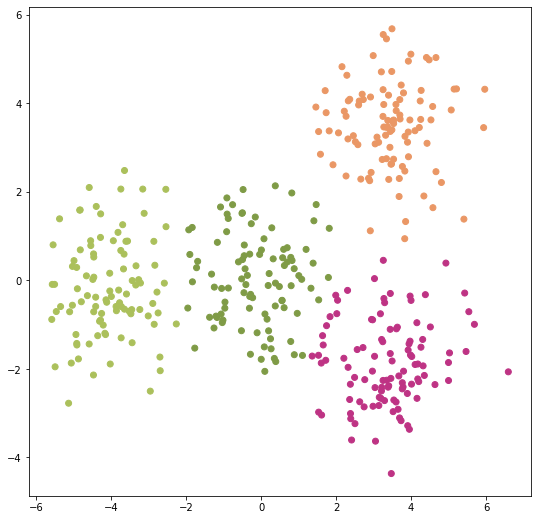

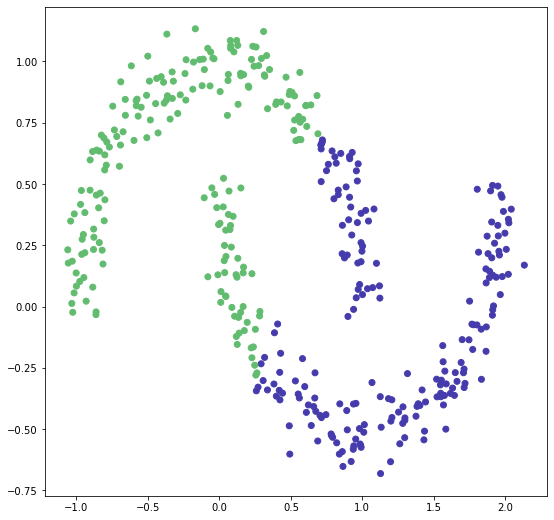

In [9]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=5)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=5)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [5]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        return
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        eps = self.eps
        min_samples = self.min_samples
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        core_samples = np.array([i for i in range(X.shape[0])
                                 if len(tree.query_radius([X[i]], r=eps)[0]) >= min_samples])
        cluster = np.array([-1] * X.shape[0])
        current_color = 0
        while -1 in cluster[core_samples]:
            cores_to_process = []
            for el in core_samples:
                if cluster[el] == -1:
                    cores_to_process.append(el)
                    break
            while cores_to_process:
                current_core_sample = cores_to_process[0]
                del cores_to_process[0]
                cluster[current_core_sample] = current_color
                for j in tree.query_radius([X[current_core_sample]], r=eps)[0]:
                    if j in core_samples and cluster[j] == -1:
                        cores_to_process.append(j)
                    cluster[j] = current_color
            current_color += 1
        return cluster


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

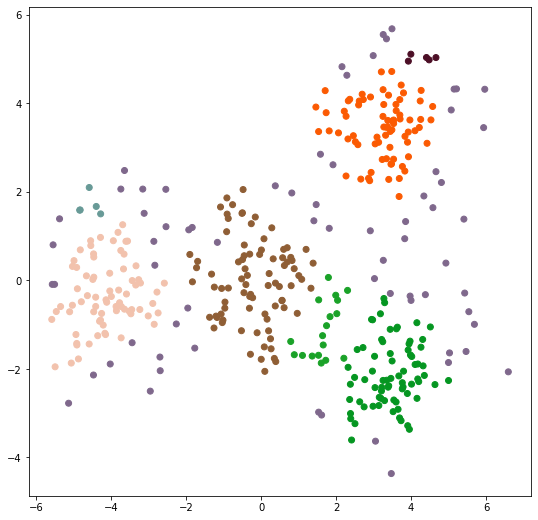

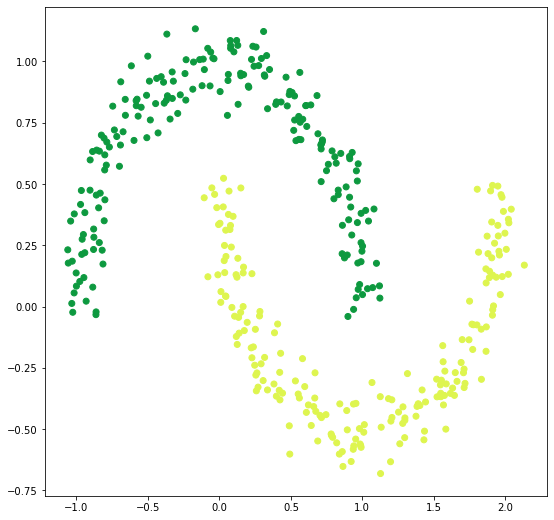

In [11]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [6]:
class AgglomertiveClustering:

    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
    
    def d(self, old_dist):
        if self.linkage == 'average':
            return old_dist.mean()
        elif self.linkage == 'single':
            return old_dist.min()
        elif self.linkage == 'complete':
            return old_dist.max()
        else:
            raise ValueError("What do you mean, maaan?")
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        n = X.shape[0]
        point_dist = np.zeros((n, n))
        for i, x in enumerate(X):
            point_dist[:, i] = point_dist[i, :] = np.linalg.norm(X - x, axis=1)
            point_dist[i, i] = np.inf
        
        clusters = [[i] for i in range(n)]
        for _ in tqdm(range(n - self.n_clusters)):
            
            min_dist = np.inf
            min_i, min_j = None, None
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    cross_dist = np.array([point_dist[k, clusters[j]] for k in clusters[i]])
                    cur_dist = self.d(cross_dist)
                    if cur_dist < min_dist:
                        min_dist = cur_dist
                        min_i, min_j = i, j
            
            i, j = min_i, min_j
            clusters[i] += clusters[j]
            del clusters[j]
            
        labels = np.array([0 for i in range(n)])
        for i, points in enumerate(clusters):
            for point in points:
                labels[point] = i

        return labels


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

100%|████████████████████████████████████████████████████████████████████████████████| 396/396 [05:06<00:00,  1.29it/s]


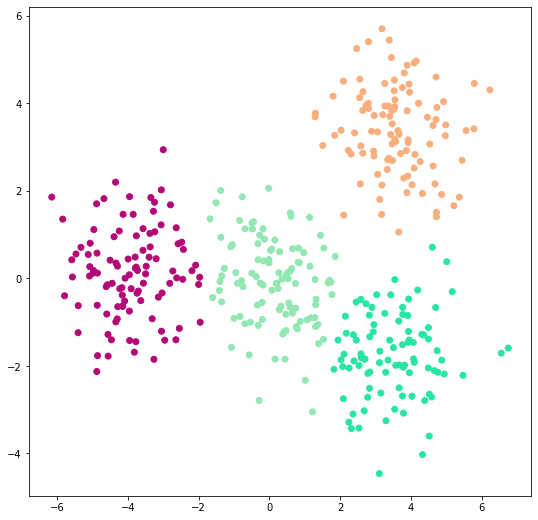

100%|████████████████████████████████████████████████████████████████████████████████| 398/398 [05:05<00:00,  1.30it/s]


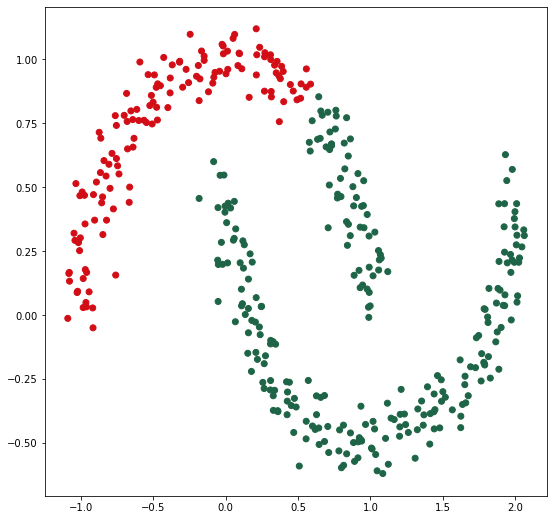

In [11]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

100%|████████████████████████████████████████████████████████████████████████████████| 398/398 [04:21<00:00,  1.52it/s]


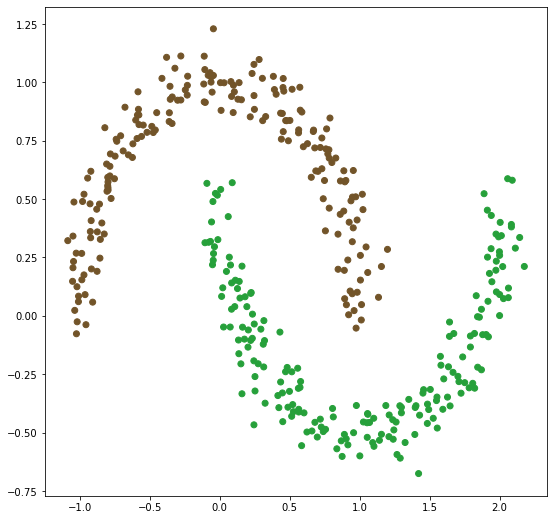

In [8]:
agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [7]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(np.float32(image * 255), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

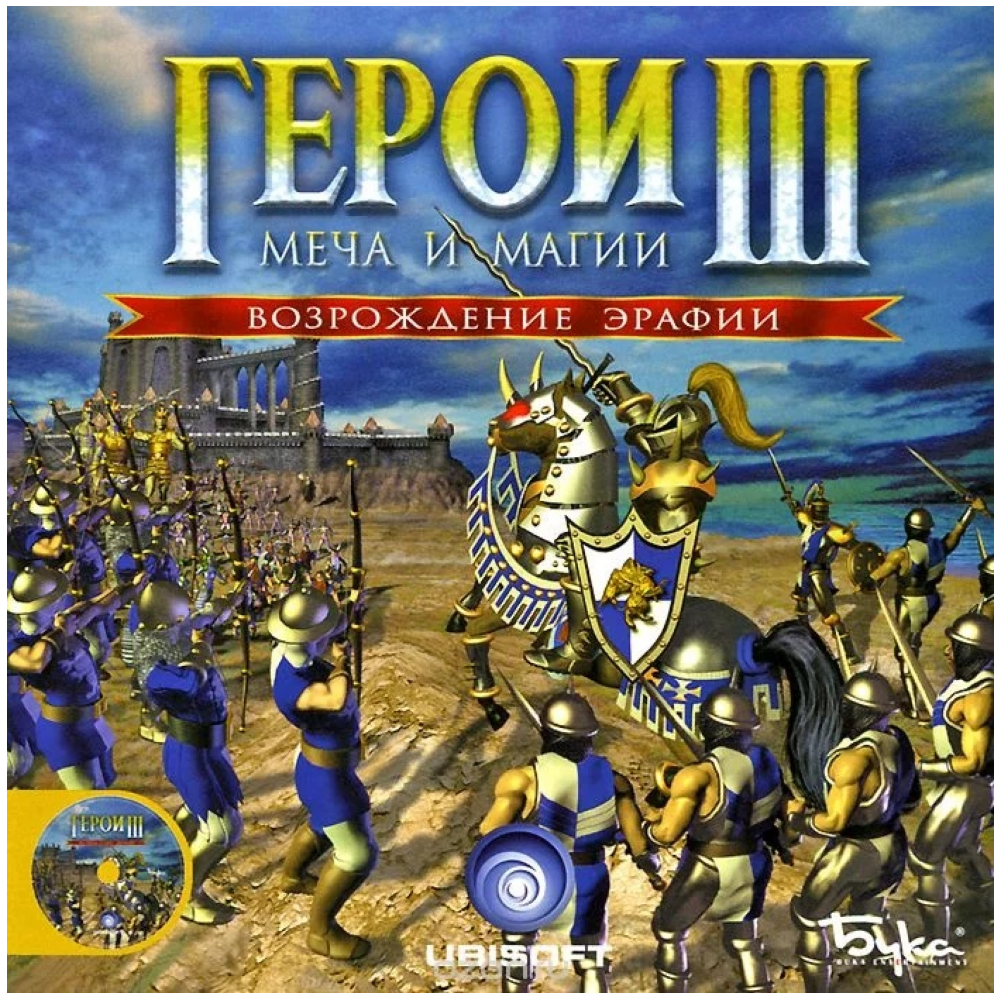

In [11]:
show_image(read_image("heroes2.jpg"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [12]:
def clusterize_image(image, clusters):
    shape = image.shape
    small_image = image[::4,::4,:]
    small_image = small_image.reshape((-1, shape[-1]))
    image = image.reshape((-1, shape[-1]))
    
    kmeans = KMeans(n_clusters=clusters, init='k-means++', max_iter=15)
    kmeans.fit(small_image)
    clusters = kmeans.predict(image)
    cluster_colors = kmeans.centroids
    recolored = np.array([cluster_colors[i] for i in clusters])
    
    #clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored.reshape(shape)

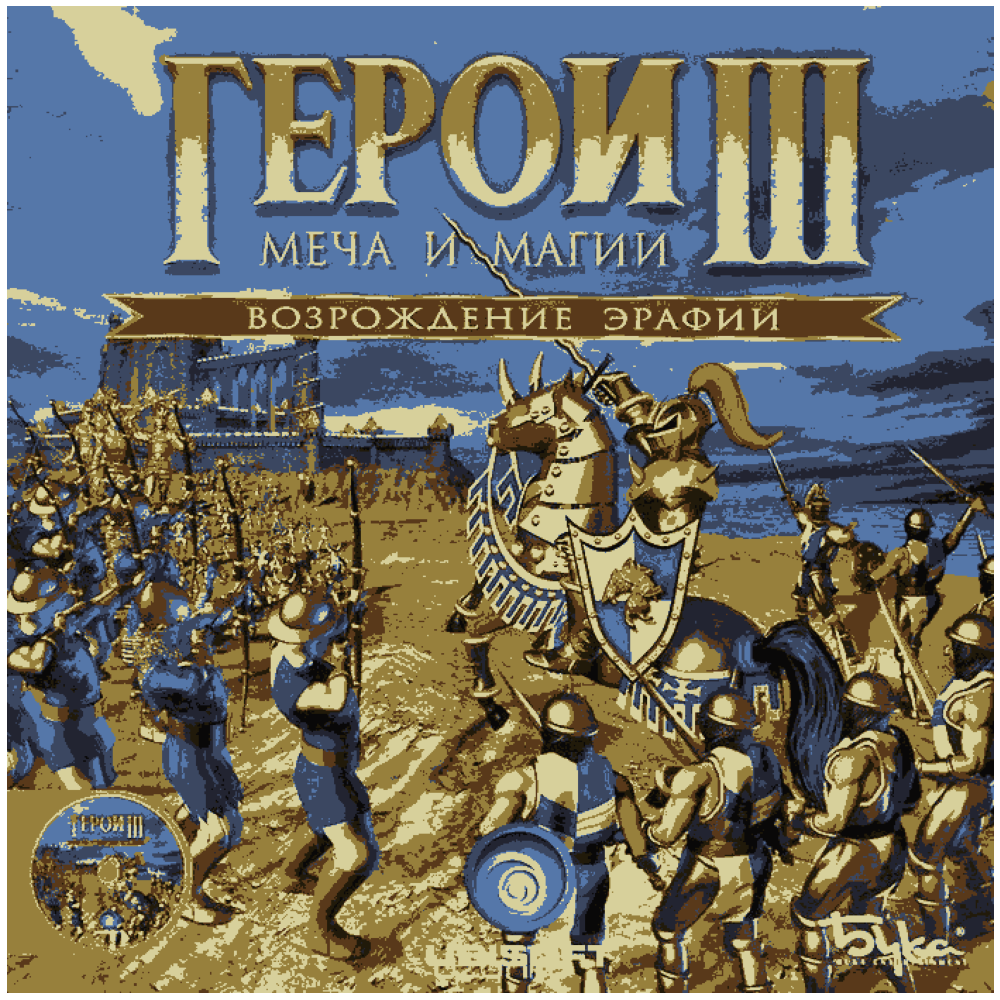

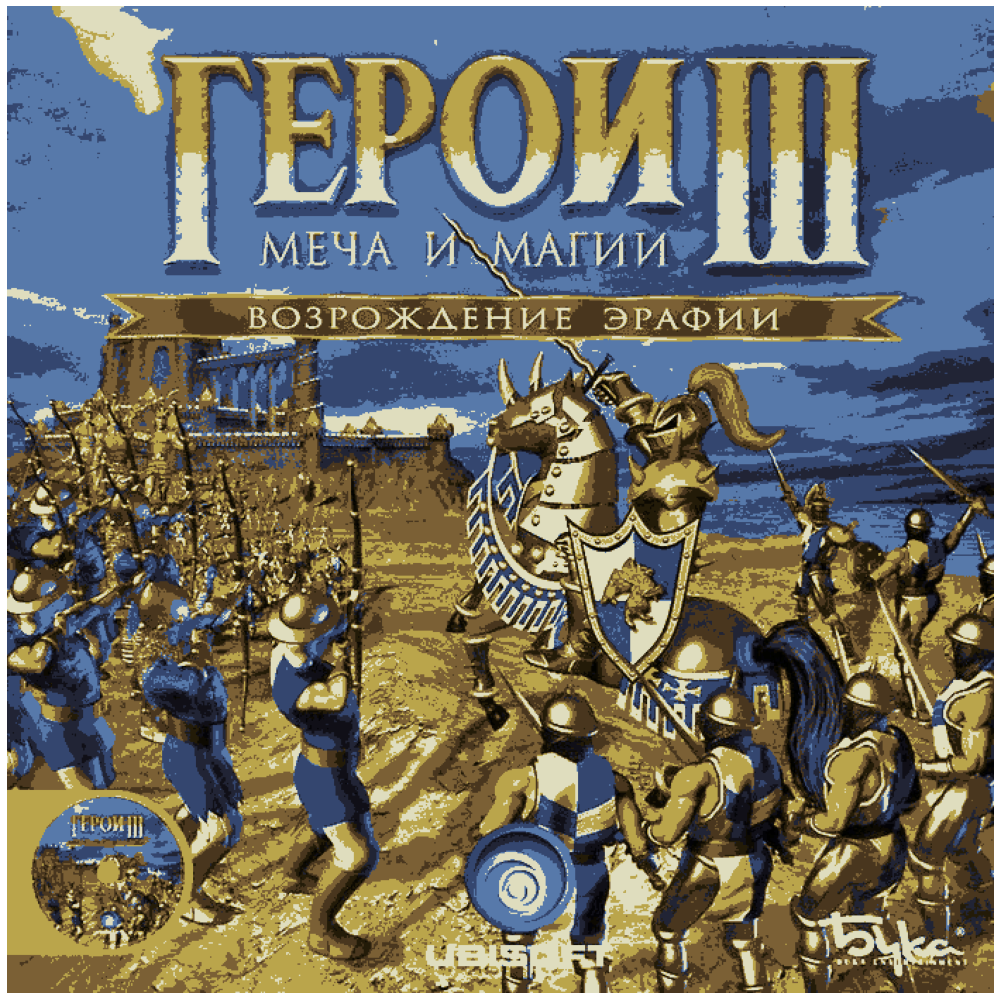

In [14]:
for i in [8, 16]:
    image = read_image("heroes2.jpg")
    result = clusterize_image(image, clusters=i)
    show_image(result)
    save_image(result, "heroes2_result" + str(i) + ".jpg")

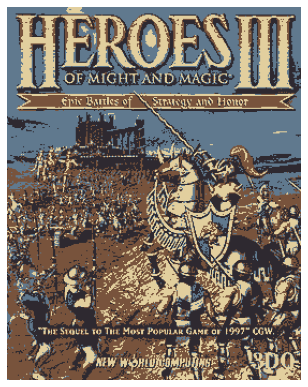

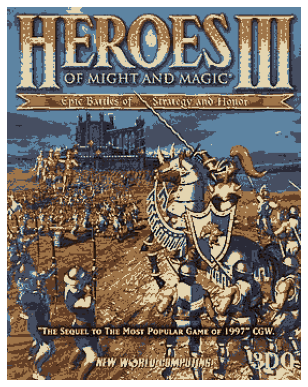

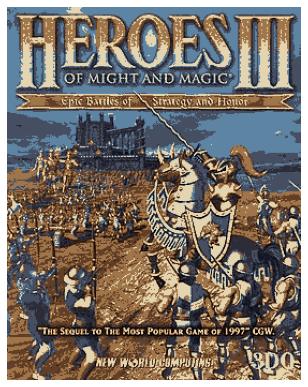

In [15]:
for i in [4, 8, 16]:
    image = read_image("heroes1.jpg")
    result = clusterize_image(image, clusters=i)
    show_image(result)
    save_image(result, "heroes1_result" + str(i) + ".jpg")